## Bus Factor: How high is the risk to a project should the most active people leave?

Bus factor quantifies the amount of contributors a project can afford to lose before it stalls by hypothetically having these people get run over a bus. Typically, it is the smallest number of people that make up 50% of contributions. 

In this notebook, we analyze bus factor according to a user-inputted percent of contributions with the option to parameterize by a time window and step size. We explore contributors including but not limited to individuals **1) making commits, 2) creating issues, and 3) creating, reviewing, and engaging in conversation around PRs**.

**Note:** In the notebook, we use the Ansible repository as an example but our analyses can be replicated with any GitHub repository.

### Table of Contents
- [1. Connect to Augur database](#connect-to-augur-database)
- [2. Query data](#query-data)
- [3. Calculate bus factor](#calculate-bus-factor)
- [4. Bus factor by number of commits](#bus-factor-by-number-of-commits)
- [5. Bus factor by number of issues](#bus-factor-by-number-of-issues)
- [6. Bus factor by number of PRs](#bus-factor-by-number-of-prs)
- [7. Conclusion](#conclusion)

In [1]:
!pip install -q sqlalchemy

In [2]:
# import the required libraries and packages
import sqlalchemy as salc
import json
import os

import psycopg2
import pandas as pd 
import numpy as np
from scipy import stats

import datetime as dt
from dateutil.relativedelta import relativedelta

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import random

import warnings
warnings.filterwarnings('ignore')

## Connect to Augur database

In [3]:
# connect to db
import json
import os

paths = ["../../comm_cage.json", "comm_cage.json", "../../config.json", "../config.json", "config.json"]

for path in paths:
    if os.path.exists(path):
        with open(path) as config_file:
            config = json.load(config_file)
        break
else:
    raise FileNotFoundError(f"None of the config files found: {paths}")
        
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Query data
Let's first define some functions that will help us organize the data in a data frame, remove contributors that are potential bots, and count the number of contributions each individual has made.  

In [4]:
def get_df(repo_query):
    '''
    :param repo_query: A string representing a SQL statement
    
    returns a DataFrame where the columns are contrb_id, their contribution type, and the commit date 
    '''
    df = pd.read_sql_query(repo_query, con=engine.connect())
    df = df.reset_index()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    df.drop('index', axis=1, inplace=True)
    return df

In [5]:
def filter_rows(df, patterns=['bot'], colname='email'):
    '''
    :param df: A DataFrame to screen column values out of
    :param patterns: A list of strings or regular expression, patterns to be screened out
    :param colname: A string representing the name of the column to screen patterns out of

    returns a DataFrame with columns that matched, and column used to match, dropped.
    '''
    # filter for rows in df where the column value contains any of the specifed patterns
    return df[~df[colname].isin(patterns)]


In [6]:
def count_cntrbs(df, contribution_type, patterns=['bot'], colname='email', ascending=False):
    '''
    :param df: A DataFrame 
    :param contribution_type: A string indicating the type of contribution
    :param patterns: A list representing of strings or regular expression, patterns to be screened out
    :param colname: A string representing the name of column to screen patterns out of
    :param descending: A boolean indicating the order in which the returned df columns are sorted according to bus factor, 
                      by default it is set to False which corresponds to descending order

    returns a DataFrame of cntrb_id's and a count of each of their contributions, sorted
    '''
    # remove potential bots
    df = filter_rows(df, patterns, colname)
    # count the number of contributions per contributor 
    df = (df.groupby('cntrb_id')[contribution_type].count()).to_frame()
    # sort rows according to amount of contributions
    df.sort_values(by=contribution_type, ascending=ascending, inplace=True)
    df = df.reset_index()
    return df

## Calculate bus factor

While the bus factor is typically defined using 50% as threshold for the percent of contributors a project can lose before it stalls, we're interested in a range of thresholds. In the following function `calc_bus_factor`, we've added a parameter `threshold` to do so.

Additionally, we're interested in counting the number of outliers i.e individuals who make contributions significantly above average. In our implementation, we define outliers as any contributors with contributions that are 2 or more standard deviations above the mean number of commits.

In [7]:
def calc_bus_factor(df, contribution_type, threshold):
    '''
    :param df: A DataFrame of cntrb_id's and contributions, sorted in descending order of contributions
    :param contribution_type: A String indicating the activity of interest
    :param threshold: A double indicating the cut off threshold for bus factor

    A contributor is ranked by how large of a proportion of all work they did - 
    if someone authored 350 of 1000 commits, for instance, they'll account for 35% 
    of the commits made. The list of percent contributions is ranked in descending order. 
    The ordered list is greedily processed such that the smallest list of contributors is 
    found that accounts for threshold percent of the work done for a given contribution type.
   
    returns the bus factor, cntrb_id's and number of outliers for the given contribution type
    '''
    # identify and count outliers which we define as 2 standard deviations or more above from the mean
    num_outliers = len(df[(stats.zscore(df[contribution_type]) > 2)])
  
    # calculate total number of contributions
    t_cntrbs = df[contribution_type].sum()

    # initilize empty list of to store contibutor ids for those who make up the bus factor
    cntrb_ids = []
    # initialize cumulative percent of contributions
    cum_per = 0

    # add column name cntrbs to calculate the ratio of activity to the total amount of said activity
    df["cntrbs"] = df[contribution_type] / t_cntrbs
    df = df.reset_index()
    
    # iterate through each row in df and create a running sum of percent contributions
    for _, row in df.iterrows():
        cum_per += row['cntrbs']
        cntrb_ids.append(row['cntrb_id']) # add contributor id to list 
        # if the cumulative percent of contributions is greater than or equal to the threshold, break
        if cum_per  >= threshold:
            break
    
    # calculate the bus factor
    bus_factor = len(cntrb_ids)
    return bus_factor, cntrb_ids, num_outliers

The bus factor can fluctuate over the lifetime of the project. Thus, we're interested in the analyzing the bus factor in a specific window of time and seeing how it evolves over different periods of time. We prioritize the most recent information so we create sliding windows from the end date up to and including the start date. If there is any remaining time between the start and end date, we calculate the bus factor for that slice of time, even if it is less than the window width.

In [8]:
def bus_factor_by_windows(df, contribution_type, window_width, step_size, threshold, start_date=None, end_date=None):
    ''' 
    :param df: A DataFrame of cntrb_id's, contributions, and dates
    :param contribution_type: A String indicating the activity of interest
    :param window_width: An integer representing the window in months for which the bus factor is calculated. 
    :param step_size:  An integer representing how many months the sliding window advances each iteration
    :param threshold: A double indicating the cut off threshold for bus factor
    :param start_date: A string representing start date of the interval, by default 
    :param end_date: A string representing the end data of the interval
    
    returns a DataFrame of period to, period from, cntrb_id, and bus factor for the specified window_width and step_size
    '''
    # if the start date and end date are null, set them to the first and last commit date
    if start_date == None:
        start_date = str(min(df['date']).date())
       
    if end_date == None:
        end_date = str(max(df['date']).date())
    
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")
    
    # if the window width is greater than time spanned by start date and end date, raise ValueError
    # convert the difference between the end date and start date into months
    delta_year = (end_date.year - start_date.year) 
    delta_month = (delta_year * 12) + (end_date.month - start_date.month)
    if window_width > delta_month:
         raise ValueError('The window width cannot be greater than the time spanned by the start and end date.')
    
    # if the step size is greater than window width, raise ValueError
    if step_size > window_width:
        raise ValueError('The step size cannot be greater than the window width.')
     
    window_width=relativedelta(months=window_width)
    step_size=relativedelta(months=step_size)

    bfs=[]
    cntrb_ids = []
    period_from = []
    period_to = [] 

    # calculate bus factor for each window, starting from the end date
    while True:
        period_from.append((end_date - window_width).strftime('%Y-%m-%d'))
        period_to.append(end_date.strftime('%Y-%m-%d'))

        # index df such that its rows are between the end date - window width and end date
        mask = (df['date'] >= end_date - window_width) & (df['date'] <= end_date)
        count_cntrbs_window = count_cntrbs(df.loc[mask], contribution_type)

        # calculate bus factor
        bus_factor, cntrb_id, num_outliers = calc_bus_factor(count_cntrbs_window, contribution_type, threshold)
        
        bfs.append(bus_factor)
        
        # shift the end_date by the step size
        end_date -= step_size
        
        # get the bus factor for the remaining slice, even if it is smaller than the window width
        # set flag to indicate if the remaining slice has not been calculated yet
        remaining_slice = False
        if end_date - window_width <= start_date:
            # calculate the remaining time between the current end date and start date, which will be the new window width
            last_window_width = end_date - start_date
            period_from.append((end_date - last_window_width).strftime('%Y-%m-%d'))
            period_to.append(end_date.strftime('%Y-%m-%d'))

            # index df such that its rows are betweeen the end_date - window_width and end date
            remaining_mask = (df['date'] >= end_date - last_window_width) & (df['date'] <= end_date) 
            count_cntrbs_last_window = count_cntrbs(df.loc[remaining_mask], contribution_type)
            # calculate bus factor for the remaining slice
            bus_factor, cntrb_id, num_outliers = calc_bus_factor(count_cntrbs_last_window, contribution_type, threshold)
            bfs.append(bus_factor)
            # set flag to True, indicating that the bus factor for the remaining slice has been calculated
            remaining_slice = True

        # exit loop if the remaining slice has been calculated
        if remaining_slice:
            break
        
    # create a dataframe with period to, period from, bus factor, and cntrb_ids as columns
    df = pd.DataFrame(list(zip(period_from, period_to, bfs)), columns = ['period_from', 'period_to', 'bus_factor'])
    return df

We often visualize data to get a better of understanding of it. Let's plot a line chart depicting the data generated by `bus_factor_by_windows`.

In [9]:
def plot_line_graph(df, title, xlabel, ylabel, step_size):
    '''
    :param df: A DataFrame that has period_from and bus_factor as its columns
    :param title: A String describing the context of the plot
    :param xlabel: A String assigned to the x-axis label
    :param ylabel: A String assigned to the y-axis label
    :param step_size: An integer representing how many months the sliding window advances each iteration

    returns a line graph of bus factor vs time
    '''
    fig = px.line(df, x="period_from", y="bus_factor", custom_data=["period_to"], text="bus_factor", width=800, height=500)
    
    fig.update_xaxes(fixedrange=True, tickformat="%B %Y", tickangle=45, dtick=f"M{step_size}")

    start_date = min(df['period_from'])
    fig.update_layout(title={'text':title,'x':0.5, 'xanchor':'center'},
                   xaxis_title=xlabel,
                   xaxis=dict(tick0=start_date),
                   yaxis_title=ylabel 
                )
    
    hovertemplate="<br>".join(["period from: %{x: %m-%d}", "period to: %{customdata[0]: %m-%d}"])
    fig.update_traces(textposition="top right", hovertemplate=hovertemplate, line_color="lightgreen")

    fig.show()

Now that we have all of our functions defined, let's put them to practice!

## Bus factor by number of commits

In [12]:
import ipywidgets as widgets
from IPython.display import display, clear_output

repo_name_w = widgets.Text(
    value='augur',
    placeholder='Enter repository name',
    description='Repo name:',
)
repo_statement_w = widgets.Text(
    value='[1]',
    placeholder='Enter repo statement (e.g. [28336])',
    description='Statement:',
)
submit_btn = widgets.Button(description='Use these', button_style='primary')
out = widgets.Output()

def on_submit(_):
    with out:
        clear_output()
        repo_name = repo_name_w.value.strip()
        repo_statement = repo_statement_w.value.strip("[]")
        # store for later cells
        globals()['repo_name'] = repo_name
        globals()['repo_statement'] = repo_statement
        print(f"✅ Repo name: {repo_name}")
        print(f"✅ Repo statement: {repo_statement}")

submit_btn.on_click(on_submit)
display(widgets.VBox([repo_name_w, repo_statement_w, submit_btn, out]))

In [13]:
#repo_name = 'Ansible'
#repo_statement = str([28336])
#repo_statement = repo_statement[1:-1]

repo_query = salc.sql.text(f"""
                SELECT
                   DISTINCT c.cmt_commit_hash AS commit,
                   ca.cntrb_id, 
                   c.cmt_author_email AS email,
                   c.cmt_author_date AS date        
                FROM
                    contributors_aliases ca
                JOIN 
                    commits c 
                ON 
                    c.cmt_committer_email = ca.alias_email
                WHERE
                    c.repo_id in({repo_statement})
               """)

In [14]:
# organize commits data in a DataFrame
conn_commits = get_df(repo_query)
display(conn_commits.head())

,commit,cntrb_id,email,date
0,01c88187ea792cb2080620b2a6b8c8e6d45f05bd,0103aa24-2600-0000-0000-000000000000,61482022+ABrain7710@users.noreply.github.com,2022-07-19
1,7f983e61df14914040a908f00a859fe5373d00ff,0103aa24-2600-0000-0000-000000000000,61482022+ABrain7710@users.noreply.github.com,2022-07-25
2,fcc59cc107d86ab7360631cb37e8a76bdd7a048c,0101e100-7300-0000-0000-000000000000,ccarterlandis@pm.me,2020-01-17
3,b0ed5181e6a1e7dd1362b25cfe8181721d7a1299,010177f7-2400-0000-0000-000000000000,imilarsky@gmail.com,2022-06-23
4,f74ad33a2228d4e17df64ca2449058f36d218de6,0102b055-e200-0000-0000-000000000000,michaelwoodruffdev@gmail.com,2020-02-01


In [15]:
# count the number of commits per contributor and order the rows from most to least number of commits
commits = count_cntrbs(df=conn_commits, contribution_type='commit', patterns=['bot'], colname='email')
# display the top 5 most active contributors
display(commits.head())

,cntrb_id,commit
0,010005cb-c700-0000-0000-000000000000,2906
1,01012f1b-7f00-0000-0000-000000000000,2470
2,010177f7-2400-0000-0000-000000000000,1618
3,0103aa24-2600-0000-0000-000000000000,1407
4,01013cd8-ae00-0000-0000-000000000000,839


In [16]:
bf_commits, cntrb_ids, num_outliers = calc_bus_factor(df=commits, contribution_type='commit', threshold=0.50)
print(f'The bus factor in terms of number of commits for {repo_name} is {bf_commits}.\nOf the total number of contributors, {num_outliers} were identified as outliers.')

The bus factor in terms of number of commits for augur is 3.
Of the total number of contributors, 4 were identified as outliers.


Now let's analyze how the bus factor has evolved over the entire lifetime of the Ansible by taking window sizes of 6 months and sliding by a step size of 4 months.

In [17]:
commits_bf_by_windows = bus_factor_by_windows(df=conn_commits, contribution_type='commit', window_width=6, step_size=4, threshold=0.5)
display(commits_bf_by_windows.head())

,period_from,period_to,bus_factor
0,2024-11-07,2025-05-07,2
1,2024-07-07,2025-01-07,2
2,2024-03-07,2024-09-07,2
3,2023-11-07,2024-05-07,2
4,2023-07-07,2024-01-07,2


In order to get a better sense of how the bus factor has evolved overtime, let's plot a line graph!

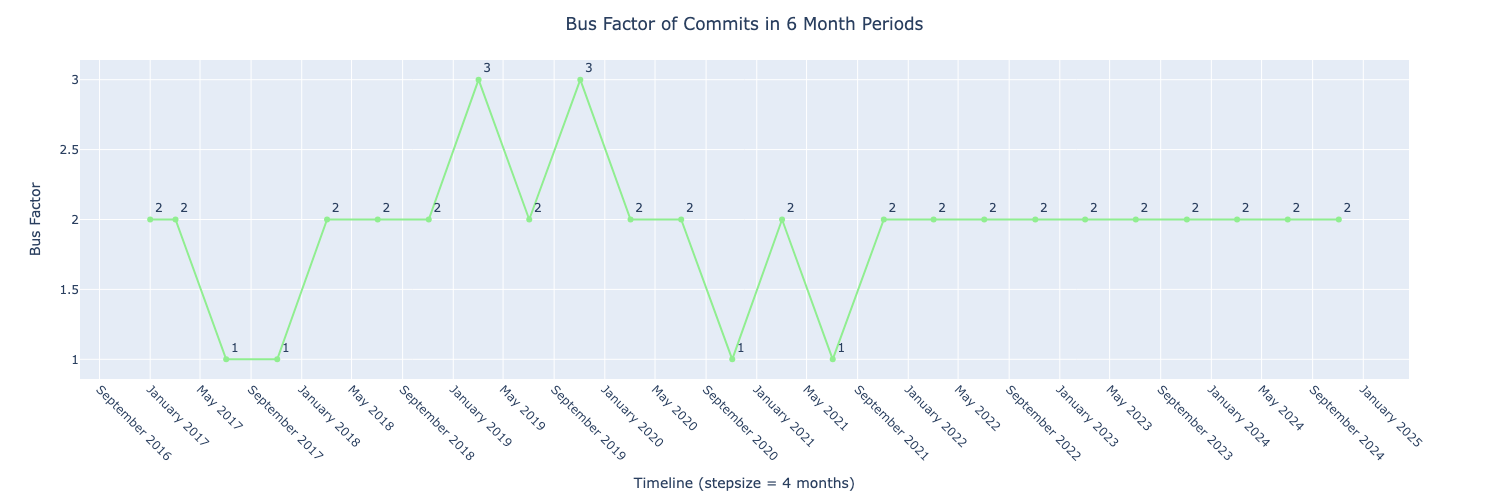

In [18]:
plot_line_graph(df=commits_bf_by_windows, 
               title='Bus Factor of Commits in 6 Month Periods', 
               xlabel='Timeline (stepsize = 4 months)',
               ylabel='Bus Factor', 
               step_size=4)

Now that we've analyzed the bus factor for one type of contribution to a project, let's explore others. Not only are contributors individuals who have directly committed to the project but also those who have contributed by creating issues.

## Bus factor by number of issues

Let's analyze the bus factor for the number of issues created.

In [19]:
issues_query = salc.sql.text(f"""
                SELECT
                    DISTINCT i.issue_id AS issue,
                    i.reporter_id AS cntrb_id,
                    ca.alias_email as email,
                    i.created_at AS date
                FROM
                    issues i, 
                    contributors_aliases ca
                WHERE
                    i.repo_id in({repo_statement}) AND
                    i.reporter_id = ca.cntrb_id
               """)

conn_issues = get_df(issues_query)
display(conn_issues.head())

,issue,cntrb_id,email,date
0,31212,0103aa24-2600-0000-0000-000000000000,61482022+ABrain7710@users.noreply.github.com,2023-04-25 13:45:30
1,31212,0103aa24-2600-0000-0000-000000000000,andrewbrain2019@gmail.com,2023-04-25 13:45:30
2,31213,0103aa24-2600-0000-0000-000000000000,61482022+ABrain7710@users.noreply.github.com,2023-04-21 21:53:02
3,31213,0103aa24-2600-0000-0000-000000000000,andrewbrain2019@gmail.com,2023-04-21 21:53:02
4,31214,0103aa24-2600-0000-0000-000000000000,61482022+ABrain7710@users.noreply.github.com,2023-04-21 19:21:37


In [20]:
issues_created = count_cntrbs(df=conn_issues, contribution_type='issue')
display(issues_created.head())

,cntrb_id,issue
0,010005cb-c700-0000-0000-000000000000,2177
1,0101e100-7300-0000-0000-000000000000,136
2,0102d4dd-e200-0000-0000-000000000000,102
3,010001c1-ca00-0000-0000-000000000000,68
4,01021550-ba00-0000-0000-000000000000,58


In [21]:
bf_issues, cntrb_ids, num_outliers = calc_bus_factor(issues_created, contribution_type='issue', threshold=0.50)
print(f'The bus factor in terms of number of issues created for {repo_name} is {bf_issues}.\nOf the total number of contributors, {num_outliers} were identified as outliers.')

The bus factor in terms of number of issues created for augur is 1.
Of the total number of contributors, 1 were identified as outliers.


Similar to the previous analysis, we performed on the number of commits, let's calculate the bus factor for issues created in windows of 6 months with a step size of 4 months over the entire lifetime of Ansible and plot it.

In [22]:
issue_bf_by_windows = bus_factor_by_windows(df=conn_issues, contribution_type='issue', window_width=6, step_size=4, threshold=0.5)
display(issue_bf_by_windows.head())

,period_from,period_to,bus_factor
0,2024-12-13,2025-06-13,2
1,2024-08-13,2025-02-13,1
2,2024-04-13,2024-10-13,1
3,2023-12-13,2024-06-13,3
4,2023-08-13,2024-02-13,1


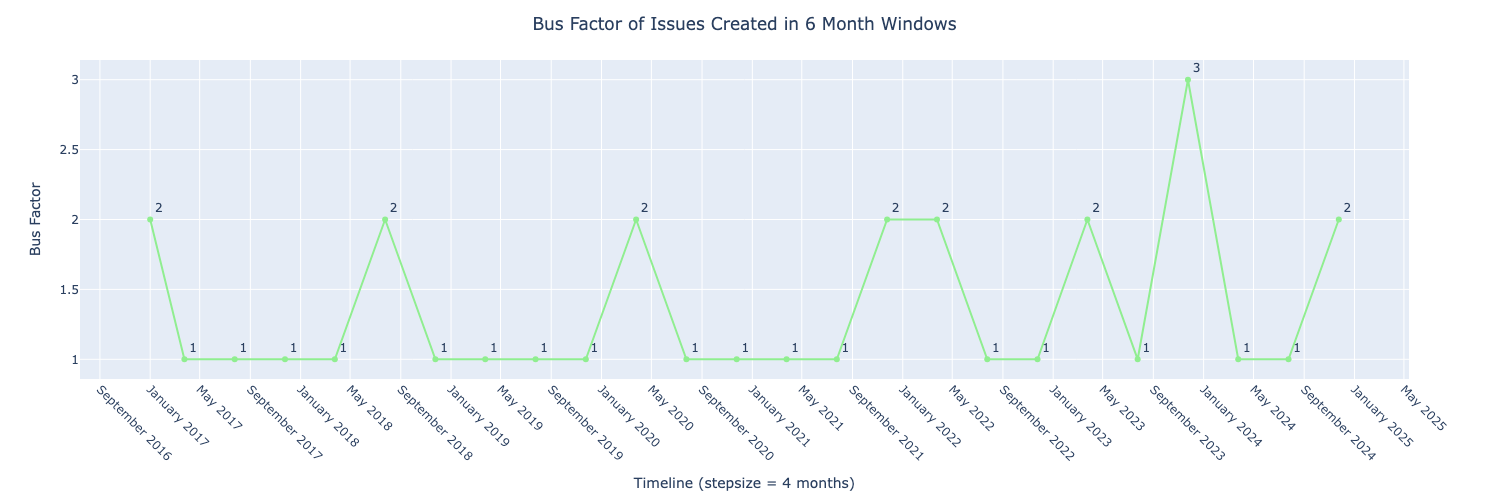

In [23]:
plot_line_graph(df=issue_bf_by_windows, 
               title='Bus Factor of Issues Created in 6 Month Windows',
               xlabel='Timeline (stepsize = 4 months)', 
               ylabel='Bus Factor', 
               step_size=4)

We can further extend our notion of bus factor by number of PRs. Here we calculate bus factor seperately for contributors who have created PRs, contributors who have reviewed PRs, and individuals who have contributed to conversation around PRs.

## Bus factor by number of PRs
- Created PRs
- Reviewed PRs
- Made comments

In [24]:
pr_create_query = salc.sql.text(f"""
                    SELECT 
                        DISTINCT pr.pull_request_id as pr, 
                        pr.pr_augur_contributor_id AS cntrb_id, 
                        ca.alias_email as email, 
                        pr.pr_created_at as date
                    FROM
                        repo r,
                        pull_requests pr, 
                        contributors_aliases ca
                    WHERE
                        r.repo_id in({repo_statement}) AND
                        pr.repo_id = r.repo_id AND
                        pr.pr_augur_contributor_id = ca.cntrb_id
            """)

conn_pr_created = get_df(pr_create_query)
display(conn_pr_created.head())

,pr,cntrb_id,email,date
0,25918,0103aa24-2600-0000-0000-000000000000,61482022+ABrain7710@users.noreply.github.com,2023-04-28 21:04:09
1,25918,0103aa24-2600-0000-0000-000000000000,andrewbrain2019@gmail.com,2023-04-28 21:04:09
2,25919,010177f7-2400-0000-0000-000000000000,imilarsky@gmail.com,2023-04-28 19:00:31
3,25919,010177f7-2400-0000-0000-000000000000,isaac@isaac-suse.dhcp.missouri.edu,2023-04-28 19:00:31
4,25919,010177f7-2400-0000-0000-000000000000,isaac.milarsky@cms.hhs.gov,2023-04-28 19:00:31


In [25]:
pr_created = count_cntrbs(df=conn_pr_created, contribution_type='pr')
display(pr_created.head())

,cntrb_id,pr
0,010005cb-c700-0000-0000-000000000000,5355
1,010177f7-2400-0000-0000-000000000000,820
2,0103aa24-2600-0000-0000-000000000000,478
3,0101e100-7300-0000-0000-000000000000,376
4,0102f65a-0500-0000-0000-000000000000,274


In [26]:
bf_pr_created, cntrb_ids, num_outliers = calc_bus_factor(df=pr_created, contribution_type='pr', threshold=0.50)
print(f'The bus factor in terms of contributors who created PRs {repo_name} is {bf_pr_created}.\nOf the total number of contributors, {num_outliers} were identified as outliers.')

The bus factor in terms of contributors who created PRs augur is 1.
Of the total number of contributors, 1 were identified as outliers.


In [27]:
pr_created_bf_by_windows = bus_factor_by_windows(df=conn_pr_created, contribution_type='pr', window_width=6, step_size=4, threshold=0.5)
display(pr_created_bf_by_windows.head())

,period_from,period_to,bus_factor
0,2024-12-14,2025-06-14,1
1,2024-08-14,2025-02-14,1
2,2024-04-14,2024-10-14,1
3,2023-12-14,2024-06-14,1
4,2023-08-14,2024-02-14,1


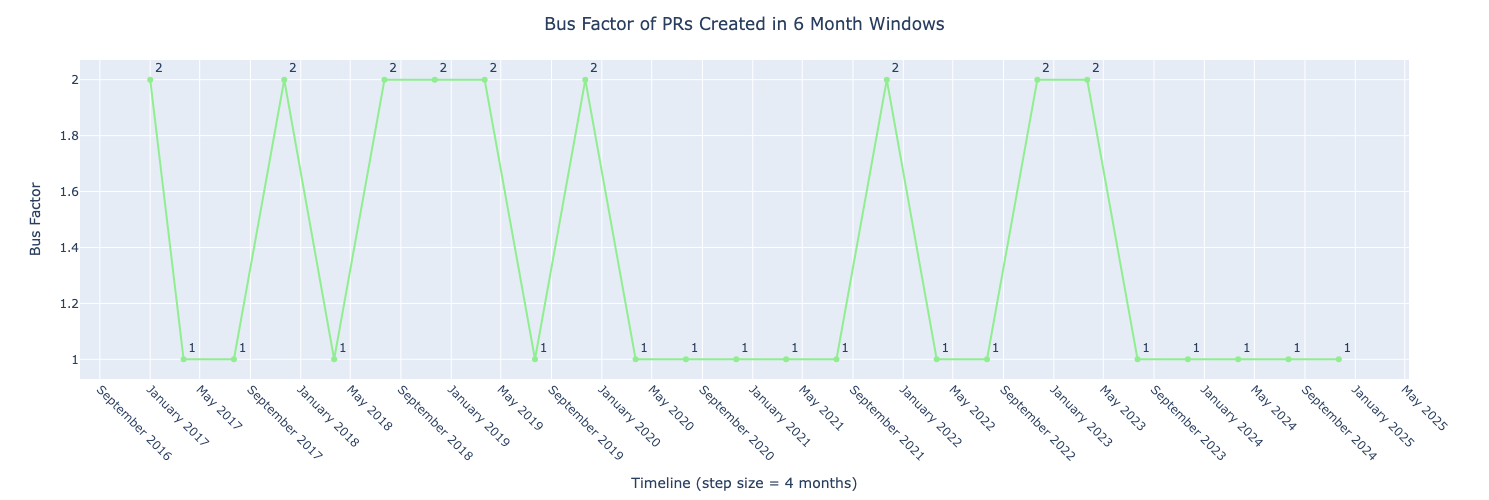

In [28]:
plot_line_graph(df=pr_created_bf_by_windows, 
               title='Bus Factor of PRs Created in 6 Month Windows',
               xlabel='Timeline (step size = 4 months)', 
               ylabel='Bus Factor', 
               step_size=4)

Let's repeat the process for reviewers.

In [29]:
pr_review_query = salc.sql.text(f"""
                    SELECT 
                        pre.pull_request_id as pr, 
                        pre.cntrb_id, 
                        ca.alias_email as email, 
                        pre.created_at as date
                    FROM
                        repo r,
                        pull_request_events pre,  
                        contributors_aliases ca
                    WHERE
                        r.repo_id in({repo_statement}) AND
                        r.repo_id = pre.repo_id AND
                        pre.cntrb_id = ca.cntrb_id 
            """)

conn_pr_review = get_df(pr_review_query)
display(conn_pr_review.head())

,pr,cntrb_id,email,date
0,27670,01000a03-5000-0000-0000-000000000000,mattgermonprez@Matts-MacBook-Pro-2.local,2017-01-23 20:06:27
1,27670,01000a03-5000-0000-0000-000000000000,germonprez@gmail.com,2017-01-23 20:06:27
2,27670,01000a03-5000-0000-0000-000000000000,mattgermonprez@Matts-MacBook-Pro-2.local,2017-01-23 20:06:27
3,27670,01000a03-5000-0000-0000-000000000000,germonprez@gmail.com,2017-01-23 20:06:27
4,27670,01000cc1-1000-0000-0000-000000000000,derek@howderek.com,2017-01-23 20:49:42


In [30]:
pr_reviewed = count_cntrbs(conn_pr_review, contribution_type='pr')
display(pr_reviewed.head())

,cntrb_id,pr
0,010005cb-c700-0000-0000-000000000000,47145
1,0101e100-7300-0000-0000-000000000000,6536
2,010177f7-2400-0000-0000-000000000000,2965
3,0103aa24-2600-0000-0000-000000000000,2278
4,01013cd8-ae00-0000-0000-000000000000,1842


In [31]:
bf_pr_reviwed, cntrb_ids, num_outliers = calc_bus_factor(pr_reviewed, contribution_type='pr', threshold=0.50)
print(f'The bus factor in terms of reviewers who reviewed PRs for {repo_name} is {bf_pr_reviwed}.\nOf the total number of contributors, {num_outliers} were identified as outliers.')

The bus factor in terms of reviewers who reviewed PRs for augur is 1.
Of the total number of contributors, 1 were identified as outliers.


In [32]:
pr_reviewed_bf_by_windows = bus_factor_by_windows(conn_pr_review, contribution_type='pr', threshold=0.50, window_width=6, step_size=4)
display(pr_reviewed_bf_by_windows.head())

,period_from,period_to,bus_factor
0,2024-12-14,2025-06-14,1
1,2024-08-14,2025-02-14,1
2,2024-04-14,2024-10-14,1
3,2023-12-14,2024-06-14,1
4,2023-08-14,2024-02-14,1


In [33]:
plot_line_graph(df=pr_reviewed_bf_by_windows, 
               title='Bus Factor of PR Reviews in 6 Month Windows',
               xlabel='Timeline (stepsize = 4 months)',
               ylabel='Bus Factor', 
               step_size=4)

Not only are contributors who created and reviewed PRs integral to the health of a project. Oftentimes, commenters help facilitate the process of merging PRs by providing feedback. Thus, we are also interested in their contributions. 

In [34]:
pr_comments_query = salc.sql.text(f"""     
                SELECT            
                    DISTINCT prm.pr_msg_ref_id AS pr_msg,
					m.msg_text comment_text, 
                    m.cntrb_id,
                    ca.alias_email as email, 
                    m.msg_timestamp as date
                FROM
                	repo r,
                    pull_requests pr,
                    pull_request_message_ref prm, 
                    message m, 
                    contributors_aliases ca
                WHERE
                	m.msg_id = prm.msg_id AND
                    prm.pull_request_id = pr.pull_request_id AND
                	pr.repo_id = r.repo_id AND
                    r.repo_id = \'{repo_statement}\' AND 
                    ca.cntrb_id = m.cntrb_id
        """
                                
    )
conn_pr_comments = get_df(pr_comments_query)
display(conn_pr_comments.head())

,pr_msg,comment_text,cntrb_id,email,date
0,230467,@germonprez What is wrong with the pip install...,01000cc1-1000-0000-0000-000000000000,derek@howderek.com,2017-01-23 20:06:27
1,230467,@germonprez What is wrong with the pip install...,01000cc1-1000-0000-0000-000000000000,doombreakr@gmail.com,2017-01-23 20:06:27
2,230468,Nothing wrong with it. Happy to change. \r\n\r...,01000a03-5000-0000-0000-000000000000,germonprez@gmail.com,2017-01-23 20:48:39
3,230468,Nothing wrong with it. Happy to change. \r\n\r...,01000a03-5000-0000-0000-000000000000,mattgermonprez@Matts-MacBook-Pro-2.local,2017-01-23 20:48:39
4,230469,@germonprez Sounds good!,01000cc1-1000-0000-0000-000000000000,derek@howderek.com,2017-01-23 20:49:48


In [35]:
pr_comments = count_cntrbs(conn_pr_comments,'pr_msg' )
pr_comments.rename(columns={'pr_msg_ref_id':'pr_msg'})
display(pr_comments.head())

,cntrb_id,pr_msg
0,010005cb-c700-0000-0000-000000000000,1974
1,0101e100-7300-0000-0000-000000000000,436
2,0102f65a-0500-0000-0000-000000000000,192
3,010177f7-2400-0000-0000-000000000000,140
4,0100b728-7300-0000-0000-000000000000,63


In [36]:
bf_pr_comments, cntrb_ids, num_outliers = calc_bus_factor(pr_comments,contribution_type='pr_msg', threshold=0.50)
print(f'The bus factor in terms of number of comments on PRs for {repo_name} is {bf_pr_comments}.\nOf the total number of contributors, {num_outliers} were identified as outliers.')

The bus factor in terms of number of comments on PRs for augur is 1.
Of the total number of contributors, 1 were identified as outliers.


In [37]:
pr_comments_bf_by_windows = bus_factor_by_windows(df=conn_pr_created, contribution_type='pr', window_width=6, step_size=4, threshold=0.5)
display(pr_comments_bf_by_windows.head())

,period_from,period_to,bus_factor
0,2024-12-14,2025-06-14,1
1,2024-08-14,2025-02-14,1
2,2024-04-14,2024-10-14,1
3,2023-12-14,2024-06-14,1
4,2023-08-14,2024-02-14,1


In [38]:
plot_line_graph(df=pr_comments_bf_by_windows, 
               title='Bus Factor of PR Comments in 6 Month Windows', 
               xlabel='Timeline (step size = 4 months)',
               ylabel='Bus Factor', 
               step_size=4)

## Conclusion
Up until this point, we've been analyzing each perspective on bus factor individually. Let's compare the top 10 contributors from each perspective to see if there's a trend in the most active contributors. We can do this by plotting a pie chart for each perspective.

In [39]:
def get_top_k(df,k):
    """
    :param df: A DataFrame resulting from the count_cntrbs function
    :param k: An integer 
    
    returns a DataFrame of the top k contributors and their contributions 
    and the remaining contributors and their contributions
    """
    # index df to get first k rows and remove 'cntrbs' column
    top_k = df.iloc[:k, :2]
    # convert cntrb_id from type UUID to String
    top_k['cntrb_id'] = top_k['cntrb_id'].apply(lambda x: str(x).split('-')[0])
    
    # sort by alpha-numeric order to make it easier to map colors to contibutors
    top_k = top_k.sort_values(by='cntrb_id')
    
    t_sum = df.iloc[:,1].sum() # get the number of total contributions 
    top_k_sum = top_k.iloc[:,1].sum() # get the number of total top k contributions
    
    # calculate the remaining contributions by taking the the difference of t_sum and top_k_sum
    top_k.loc[len(top_k.index)] = ['other', t_sum - top_k_sum ]
   
    return top_k

We want to easily be able to compare the top contributors accross the different perpectives in our visualization. Let's create a dictionary mapping each unqiue contributor to a color. 

In [40]:
def create_color_map(top_k_set):
    '''
    :param top_k_set: A list of DataFrames with top contibutors according to each perspective

    returns a list mapping unique contributors to unique colors
    '''
    # get all unique contributors
    cntrb_id_set = pd.concat(top_k_set).iloc[:, 0]
    cntrb_id_set = [*set(list(cntrb_id_set))]

    # intialize list to store all colours
    colors = []

    # generate colors for each contributor
    for _ in range(len(cntrb_id_set)):
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)

        colors.append(f'rgb{r,g,b}')

    return colors

Let's get the top 10 contributors and the number of their contributions for each contribution type. All the remaining number of contributions will correspond to the cntrb_id "other".

In [41]:
# get the top 10 contributors for each contribution type
top_10_commits = get_top_k(commits, 10)
top_10_issues = get_top_k(issues_created, 10)
top_10_prs_created = get_top_k(pr_created, 10)
top_10_prs_reviewed = get_top_k(pr_reviewed, 10)
top_10_pr_comments = get_top_k(pr_comments, 10)

display(top_10_commits)

,cntrb_id,commit
0,010005cb,2906
6,01000cc1,351
7,0100b728,192
9,0100f37d,130
1,01012f1b,2470
4,01013cd8,839
8,010153aa,147
2,010177f7,1618
5,0101e100,831
3,0103aa24,1407


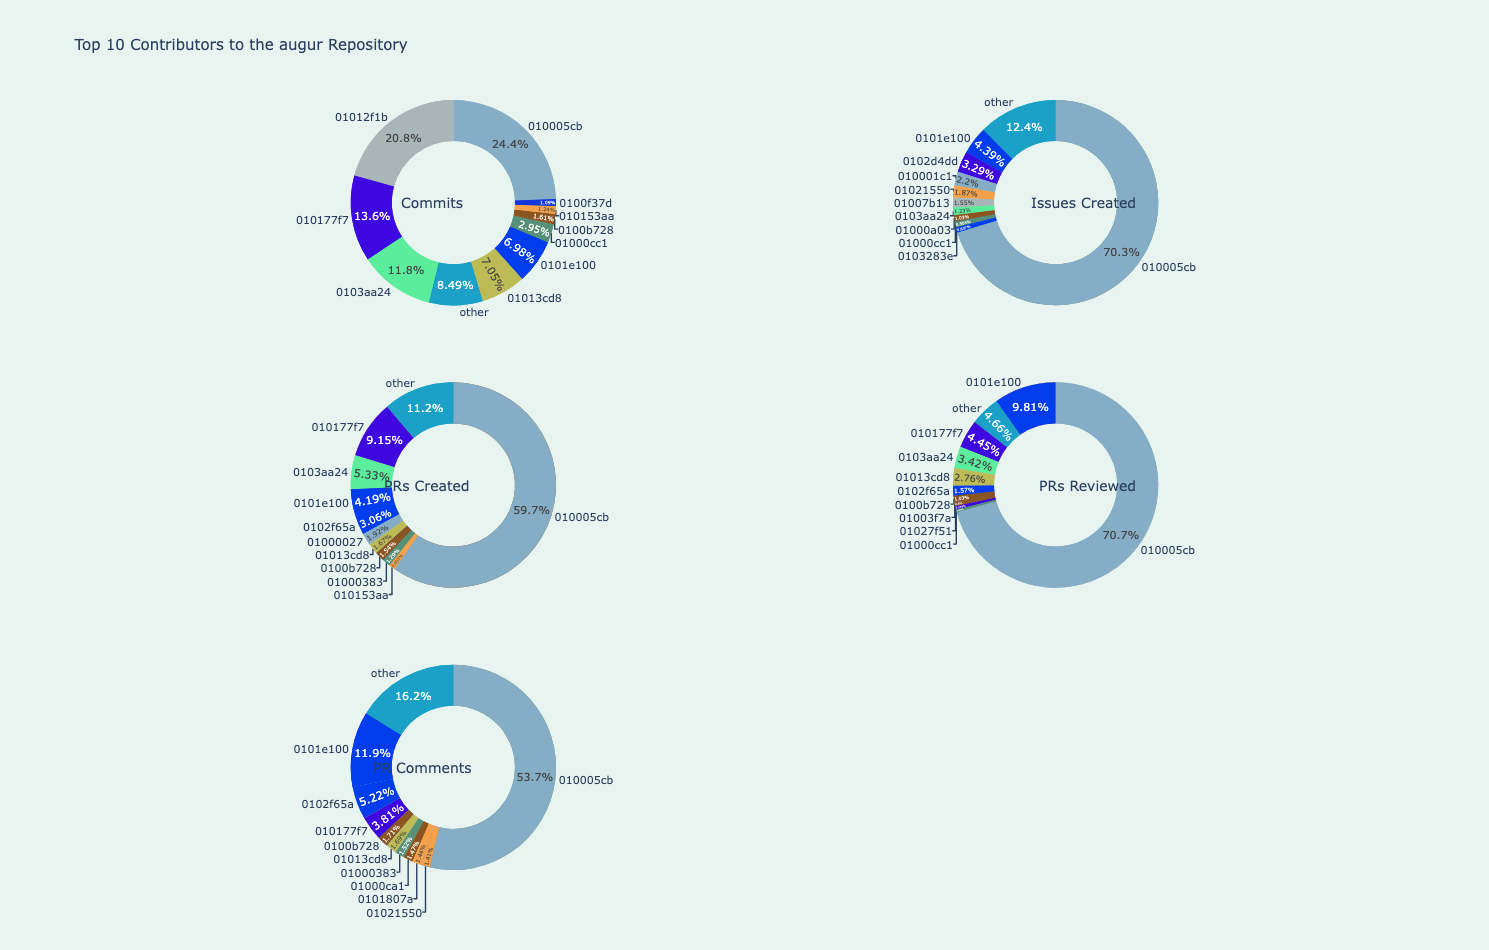

In [42]:
# store the top 10 in a list 
top_10_set = [top_10_commits, top_10_issues, top_10_prs_created, top_10_prs_reviewed, top_10_pr_comments]

# generate legend colors
colors=create_color_map(top_k_set=top_10_set)


specs = [[{'type':'domain'}, {'type':'domain'}], 
         [{'type':'domain'}, {'type':'domain'}], 
         [{'type':'domain'}, {'type':'domain'}]]

# assign how much space in the figure each donut chart takes up
domains = [
    {'x': [0.0, 0.5], 'y': [0.0, 0.33]},
    {'x': [0.5, 1.0], 'y': [0.0, 0.33]},
    {'x': [0.0, 0.5], 'y': [0.33, 0.66]},
    {'x': [0.5, 1.0], 'y': [0.33, 0.66]},
    {'x': [0.0, 0.5], 'y': [0.66, 1.0]}
]

fig = make_subplots(rows=3, cols=2, specs=specs, start_cell="top-left")
for i, df in enumerate(top_10_set):
    row, col = (i // 2) + 1, (i % 2) + 1

    common_props=dict(labels=list(df.iloc[:, 0]),values=list(df.iloc[:, 1]))
    
    fig.add_trace(go.Pie(
        **common_props,
        # name = subtitles[i],
        domain = domains[i],
        marker_colors=colors, 
        textinfo="label",
        textposition="outside",
        hole=.6), row=row, col=col)
    
    # display percent inside each wedge
    fig.add_trace(go.Pie(
        **common_props, 
        textinfo='percent',
        textposition='inside',
        hole=0.6), row=row, col=col)
    
fig.update_traces(hoverinfo='label+percent')

fig.update_layout(height=950, width=950,
                  title_text=f'Top 10 Contributors to the {repo_name} Repository',
                  paper_bgcolor='#e8f4f0',
                  annotations=[dict(text='Commits', x=0.175, y=0.88, font_size=14, showarrow=False),
                  dict(text='Issues Created', x=0.85, y=0.88, font_size=14, showarrow=False),
                  dict(text='PRs Created', x=0.16, y=0.50, font_size=14, showarrow=False), 
                  dict(text='PRs Reviewed', x=0.85, y=0.50, font_size=14, showarrow=False),
                  dict(text='PR Comments', x=0.15, y=0.12, font_size=14, showarrow=False)],
                  showlegend=False,
                  font_size=11)

fig = go.Figure(fig)

fig.show()

We can observe a trend in active contibutors among all the different perspectives we analaysed. For example, the contributor with id 01000cc2 is in the top 3 of the most active contibutors in 3 out of 5 of them. We can make the same observation for the contributor with id 01000c4d. 

Additionally, there are some activities in which the number of contributions is more evenly distributed compared to others such as creating issues vs reviewing PRs. This aligns with our logic since any user can create an issue on a repository whereas only the maintainer can review PRs.